In [1]:
# Import data from Excel sheet
import pandas as pd
#df = pd.read_excel('/content/drive/My Drive/ADNI_komplett/ADNI combined.xlsx', sheet_name='sample')
df = pd.read_excel('ADNI combined.xlsx', sheet_name='sample')
#print(df)
sid = df['RID']
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV']
field = df['MRI_Field_Strength']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataAD = sorted(glob.glob('mwp1_MNI/AD/*.nii.gz'))
dataLMCI = sorted(glob.glob('mwp1_MNI/LMCI/*.nii.gz'))
dataCN = sorted(glob.glob('mwp1_MNI/CN/*.nii.gz'))
dataFiles = dataAD + dataLMCI + dataCN
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  663  nifti files


In [3]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load residualized data from disk
import h5py
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
hf = h5py.File('residuals_wb_mwp1_MNI.hdf5', 'r')
hf.keys # read keys
labels = np.array(hf.get('labels')) # note: was of data frame type before
images = np.array(hf.get('images'))
hf.close()
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
print(images.shape)

Using TensorFlow backend.


(663, 100, 100, 120, 1)


In [5]:
# specify version of tensorflow
#%tensorflow_version 1.x
#%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
#print(tf.__version__)
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = False #True
session = tf.Session(config=config)
set_session(session)

1.15.0


In [6]:
# define function for simple data augmentation (translation of 2 vx in each x/y/z direction)
# and L/R flipping
import numpy as np
def simpleshift(arr, num, axis, fill_value=0): # adapted from https://stackoverflow.com/a/42642326
  result = np.empty_like(arr)
  if (axis==1):
    if num > 0:
        result[:, :num, :, :, :] = fill_value
        result[:, num:, :, :, :] = arr[:, :-num, :, :, :]
    elif num < 0:
        result[:, num:, :, :, :] = fill_value
        result[:, :num, :, :, :] = arr[:, -num:, :, :, :]
    else:
        result[:] = arr
    return result
  elif (axis==2):
    if num > 0:
        result[:, :, :num, :, :] = fill_value
        result[:, :, num:, :, :] = arr[:, :, :-num, :, :]
    elif num < 0:
        result[:, :, num:, :, :] = fill_value
        result[:, :, :num, :, :] = arr[:, :, -num:, :, :]
    else:
        result[:] = arr
    return result
  elif (axis==3):
    if num > 0:
        result[:, :, :, :num, :] = fill_value
        result[:, :, :, num:, :] = arr[:, :, :, :-num, :]
    elif num < 0:
        result[:, :, :, num:, :] = fill_value
        result[:, :, :, :num, :] = arr[:, :, :, -num:, :]
    else:
        result[:] = arr
    return result
  else:
    return None


Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1436    1030
1500    5241
1419     552
1422     667
1411     230
1453    4990
324     4201
359     4707
373     4801
383     4894
1377    4251
1333     698
1387    4899
1349    1072
1352    1118
1328     505
1381    4542
1338     800
1395    6180
192     4079
305     4925
1274     610
1282     751
1281     741
4        413
42      4150
92      4384
105     4421
110     4429
115     4449
126     4496
130     4506
145     4580
153     4609
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 100, 100

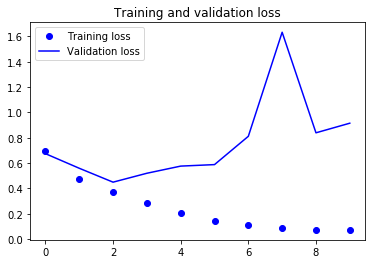

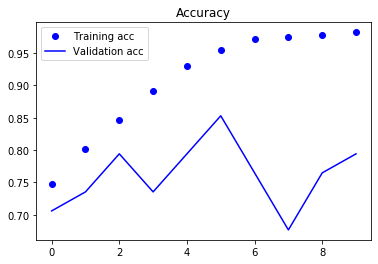

34/34 [==============================] - 0s 8ms/step
Test acc: 79.41%


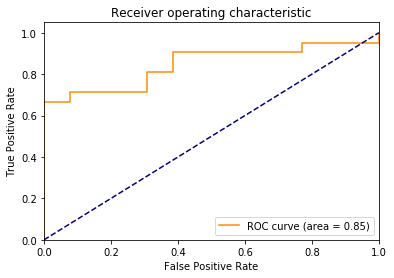

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.71
AUC for AD vs. CN = 0.99
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1502    5252
1444    1425
1443    1346
1474    5062
1415     361
339     4494
354     4672
365     4737
382     4887
393     4982
1354    1155
1339     867
1361    1300
1366    1414
1347    1052
1363    1378
199     4162
214     4303
242     4524
262     4671
266     4712
1256     159
1243      31
1296     985
1297    1016
1260     186
21      4060
45      4158
49      4176
61      4269
77      4340
123     4485
141     4576
158     4637
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
Train on 8806 samples, validate on 34 samples
Epoch 1/20
8806/8806 [==============================] - 202s 23ms/step - loss: 0.

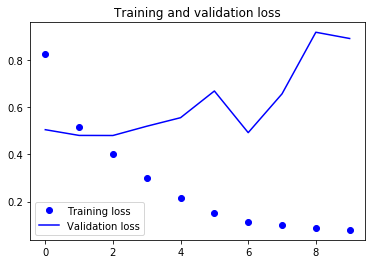

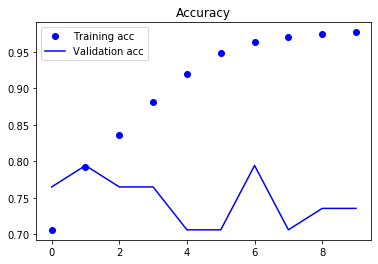

34/34 [==============================] - 0s 8ms/step
Test acc: 73.53%


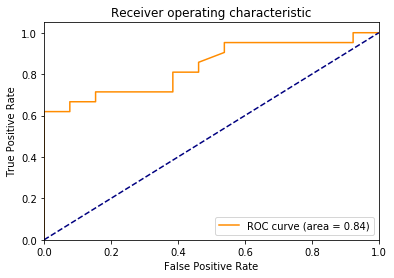

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.69
AUC for AD vs. CN = 1.00
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1490    5165
1439    1117
1462    5017
1437    1043
1460    5015
1505    6142
318     4136
334     4338
361     4719
362     4728
1326     420
1374    4203
1351    1106
183     4030
188     4057
190     4061
195     4114
233     4456
278     4757
297     4889
303     4909
1284     842
1255     130
1250      74
0         21
11      4014
22      4066
73      4320
89      4372
109     4428
134     4545
146     4585
167     4762
176     4921
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
Train on 8806 samples, validate on 34 samples
Epoch 1/20
8806/8806 [==============================] - 202s 23ms/step - loss: 0.

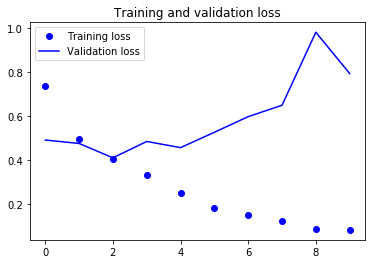

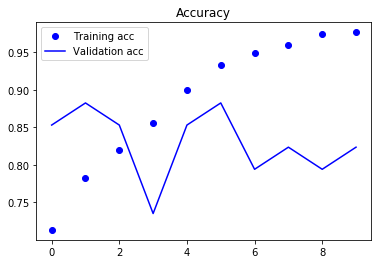

34/34 [==============================] - 0s 8ms/step
Test acc: 82.35%


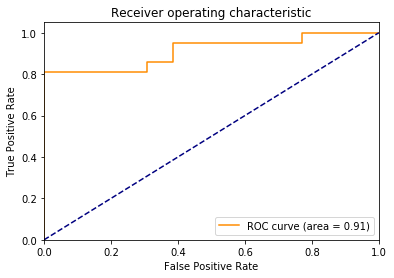

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.83
AUC for AD vs. CN = 1.00
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1468    5038
1447    4924
1485    5120
1407     160
329     4252
350     4625
370     4774
376     4827
385     4906
395     5012
1399    6334
1331     671
1322     285
1318     123
1335     717
200     4169
217     4354
229     4414
235     4462
250     4595
261     4668
1295     984
1247      59
1310    4234
1286     886
1293     969
62      4275
101     4399
102     4400
106     4422
120     4474
125     4491
131     4508
162     4645
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
Train on 8806 samples, validate on 34 samples
Epoch 1/20
8806/8806 [==============================] - 203s 23ms/step - loss: 0.

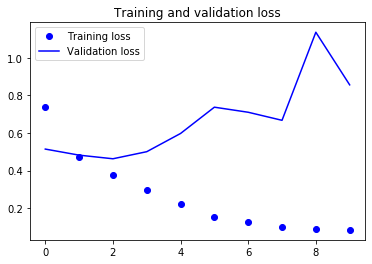

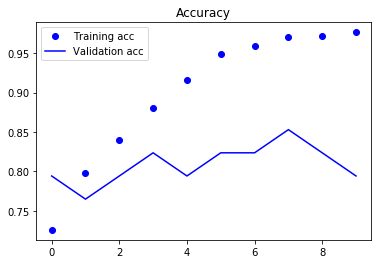

34/34 [==============================] - 0s 8ms/step
Test acc: 79.41%


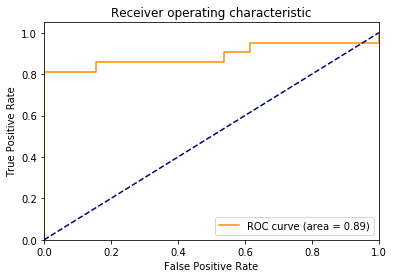

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.90
AUC for AD vs. CN = 0.88
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1466    5032
1475    5063
1494    5205
1488    5146
1456    4997
1433    1004
330     4258
357     4692
367     4756
378     4853
1350    1074
1342     919
1376    4250
1317     107
180     1268
181     4015
184     4034
186     4042
219     4363
282     4782
291     4857
1276     657
1264     260
9       4003
26      4081
29      4086
51      4179
52      4196
64      4277
68      4290
97      4389
143     4578
148     4587
172     4855
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
Train on 8806 samples, validate on 34 samples
Epoch 1/20
8806/8806 [==============================] - 202s 23ms/step - loss: 0.

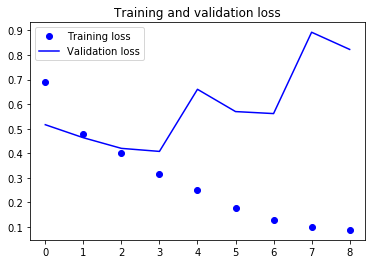

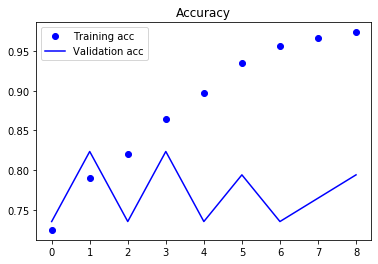

34/34 [==============================] - 0s 9ms/step
Test acc: 79.41%


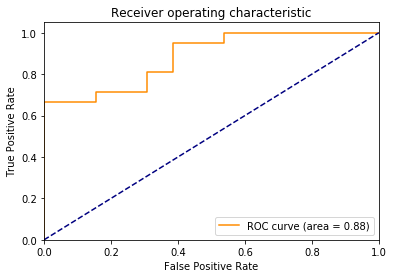

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.83
AUC for AD vs. CN = 0.94
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1484    5119
1403      42
1459    5013
1435    1010
1465    5029
1503    5275
353     4660
371     4783
372     4792
391     4954
1323     291
1343     925
1389    4928
1397    6274
231     4430
247     4582
249     4590
257     4636
269     4720
274     4741
302     4904
1266     301
1316    6051
33      4100
34      4103
38      4121
39      4125
40      4139
66      4279
69      4291
83      4352
103     4401
166     4739
169     4832
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
Train on 8806 samples, validate on 34 samples
Epoch 1/20
8806/8806 [==============================] - 202s 23ms/step - loss: 0.

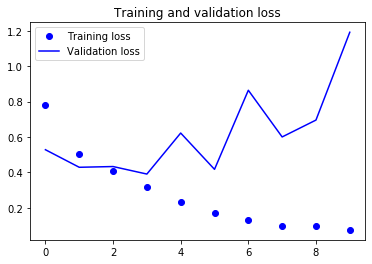

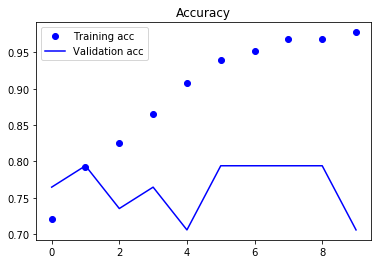

34/34 [==============================] - 0s 9ms/step
Test acc: 70.59%


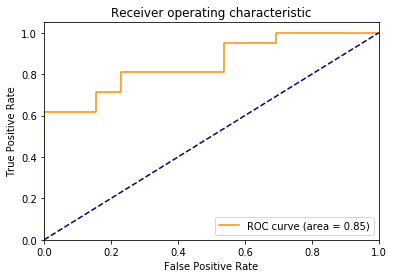

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.77
AUC for AD vs. CN = 0.95
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1420     572
1497    5224
1421     658
1409     214
1455    4994
326     4211
347     4589
351     4641
358     4696
381     4879
1391    4985
1319     142
1388    4922
1401    6356
1360    1269
1321     200
193     4094
210     4263
224     4395
284     4793
287     4815
1273     553
1280     734
1301    1232
1285     863
7       1261
10      4010
15      4026
36      4119
57      4225
79      4345
87      4369
95      4387
111     4433
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
Train on 8806 samples, validate on 34 samples
Epoch 1/20
8806/8806 [==============================] - 203s 23ms/step - loss: 0.

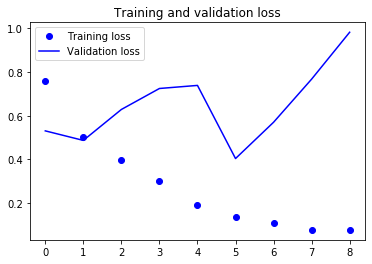

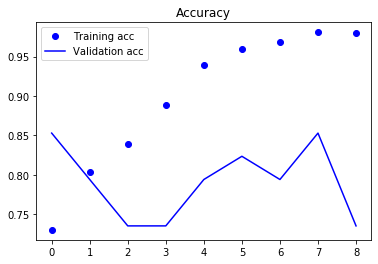

34/34 [==============================] - 0s 9ms/step
Test acc: 73.53%


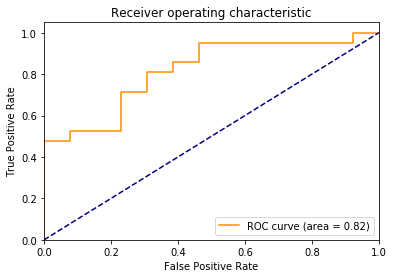

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.74
AUC for AD vs. CN = 0.90
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1479    5087
1457    5005
1477    5070
1454    4992
314     4009
316     4039
337     4379
340     4500
342     4526
390     4949
1394    6073
1386    4804
1327     454
1380    4311
1392    5047
194     4096
241     4521
276     4746
298     4892
300     4902
309     4955
1242      23
1291     926
1270     479
1289     920
1303    1352
1267     315
18      4037
37      4120
50      4177
98      4391
142     4577
160     4643
174     4878
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
Train on 8806 samples, validate on 34 samples
Epoch 1/20
8806/8806 [==============================] - 203s 23ms/step - loss: 0.

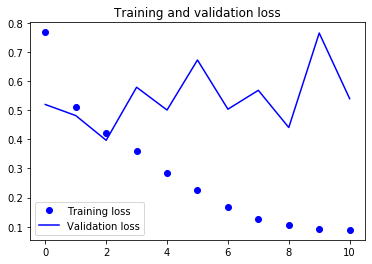

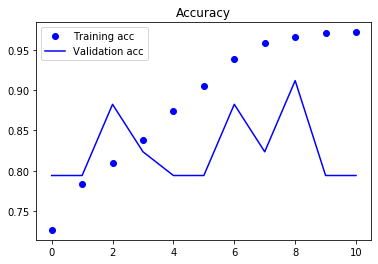

34/34 [==============================] - 0s 9ms/step
Test acc: 79.41%


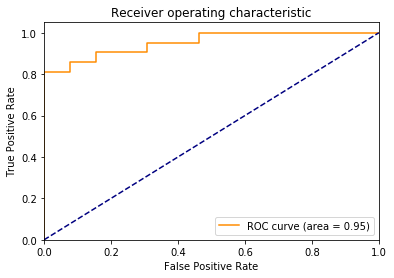

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.92
AUC for AD vs. CN = 0.98
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    179
Name: Group, dtype: int64
1405     101
1499    5240
1414     331
1452    4980
1404      51
1445    1427
1476    5067
375     4820
377     4845
394     4984
1330     644
1390    4945
1365    1408
1371    4187
226     4403
230     4426
248     4584
268     4715
286     4807
292     4869
296     4888
1254     120
1315    5040
1244      47
1         89
3        311
20      4043
44      4155
71      4308
75      4337
80      4348
147     4586
163     4649
170     4835
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
Train on 8806 samples, validate on 34 samples
Epoch 1/20
8806/8806 [==============================] - 204s 23ms/step - loss: 0.

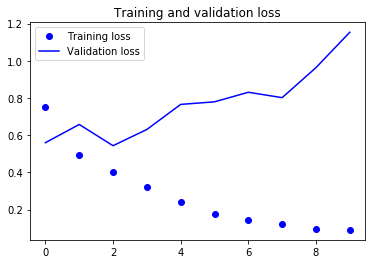

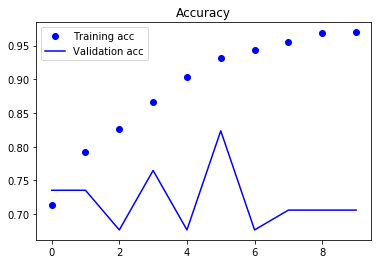

34/34 [==============================] - 0s 9ms/step
Test acc: 70.59%


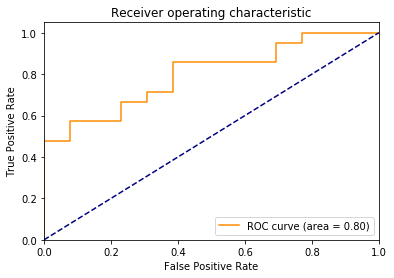

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4    10
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.79
AUC for AD vs. CN = 0.81
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1423     702
1434    1007
1446    4859
1504    6039
1410     227
317     4089
319     4152
327     4215
366     4755
1369    4115
1385    4729
1364    1380
1370    4167
198     4138
206     4219
213     4294
215     4324
218     4359
289     4842
311     4976
1309    4213
1288     907
1257     171
2        295
25      4080
43      4151
65      4278
84      4357
93      4385
108     4427
117     4464
129     4505
177     4951
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
Train on 8820 samples, validate on 33 samples
Epoch 1/20
8820/8820 [==============================] - 205s 23ms/step - loss: 0.7519 - acc: 0

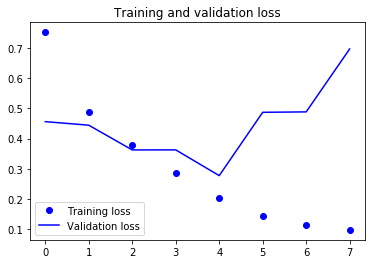

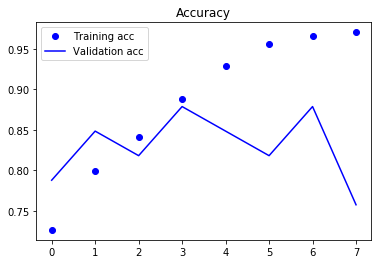

33/33 [==============================] - 0s 9ms/step
Test acc: 75.76%


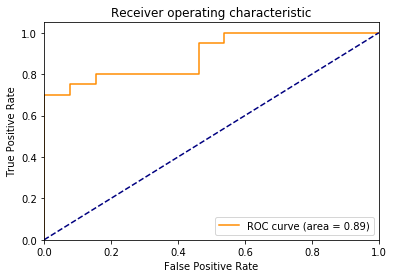

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.80
AUC for AD vs. CN = 1.00
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1478    5071
1428     887
1486    5123
315     4024
331     4280
341     4501
344     4549
345     4568
369     4772
1355    1169
1368    1419
1337     778
1398    6297
179     1186
187     4053
222     4381
246     4562
259     4653
275     4743
294     4877
1313    4872
1269     419
1275     618
1290     923
1292     934
1307    4198
23      4075
47      4173
67      4288
124     4488
154     4612
165     4688
173     4856
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
Train on 8820 samples, validate on 33 samples
Epoch 1/20
8820/8820 [==============================] - 204s 23ms/step - loss: 0.7252 - acc: 0

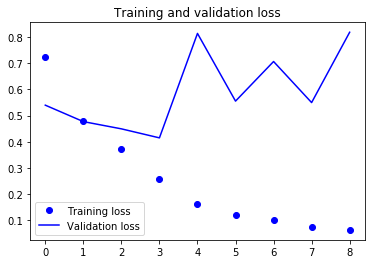

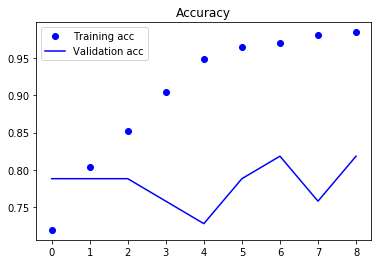

33/33 [==============================] - 0s 9ms/step
Test acc: 81.82%


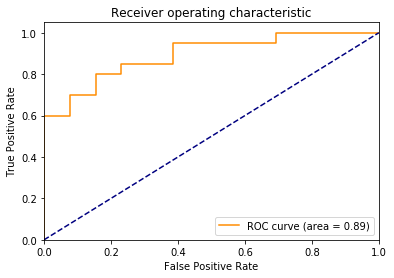

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.80
AUC for AD vs. CN = 1.00
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1467    5037
1425     830
1448    4959
1450    4968
325     4209
335     4353
379     4863
380     4867
386     4910
1353    1122
1345    1045
1324     296
197     4131
209     4244
216     4346
225     4402
265     4711
267     4713
273     4736
288     4817
1308    4208
1262     229
1272     545
1277     668
53      4200
60      4266
63      4276
72      4313
90      4376
107     4424
118     4466
121     4482
155     4616
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
Train on 8820 samples, validate on 33 samples
Epoch 1/20
8820/8820 [==============================] - 205s 23ms/step - loss: 0.6967 - acc: 0

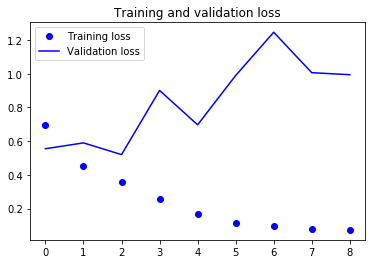

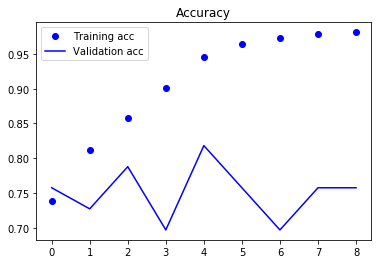

33/33 [==============================] - 0s 9ms/step
Test acc: 75.76%


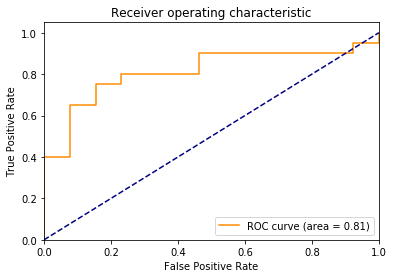

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.73
AUC for AD vs. CN = 0.91
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1449    4964
1489    5162
1461    5016
1472    5058
1427     873
1441    1255
320     4153
321     4172
333     4307
1341     908
1346    1046
1362    1318
1373    4194
1320     150
1340     872
1378    4300
1356    1187
189     4058
203     4197
271     4722
1299    1190
1263     257
1261     210
1258     172
6       1202
19      4041
48      4174
78      4343
81      4349
119     4469
138     4559
140     4566
151     4604
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
Train on 8820 samples, validate on 33 samples
Epoch 1/20
8820/8820 [==============================] - 205s 23ms/step - loss: 0.7144 - acc: 0

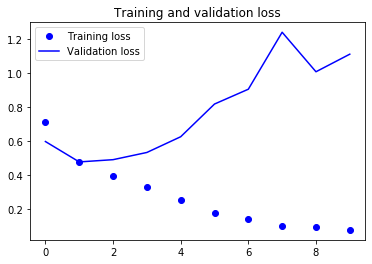

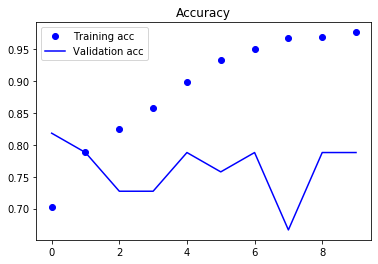

33/33 [==============================] - 0s 9ms/step
Test acc: 78.79%


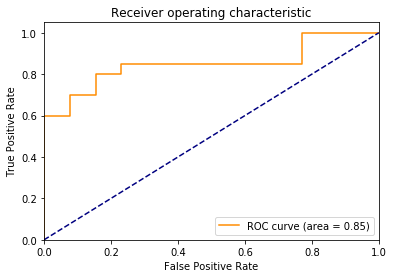

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.80
AUC for AD vs. CN = 0.91
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    241
3    209
4    180
Name: Group, dtype: int64
1442    1326
1495    5208
1482    5106
1417     378
322     4192
328     4223
343     4546
364     4732
374     4802
1329     546
1325     307
1357    1218
1332     679
1383    4630
201     4170
207     4240
211     4287
254     4626
264     4689
272     4723
1294     981
1314    5023
1304    4050
1302    1286
30      4090
58      4254
70      4292
86      4367
88      4371
100     4396
122     4483
156     4620
161     4644
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
Train on 8820 samples, validate on 33 samples
Epoch 1/20
8820/8820 [==============================] - 206s 23ms/step - loss: 0.7592 - acc: 0

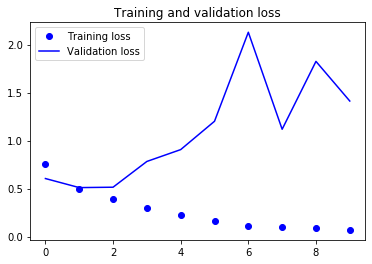

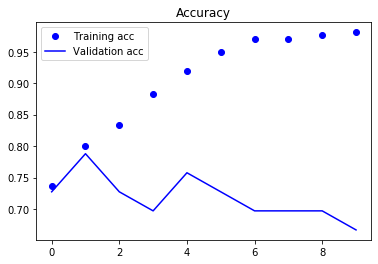

33/33 [==============================] - 0s 9ms/step
Test acc: 66.67%


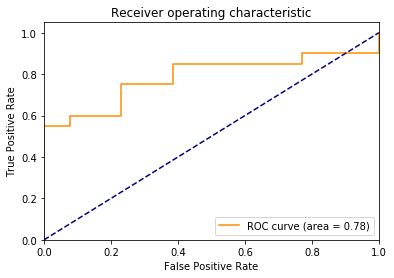

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    13
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.63
AUC for AD vs. CN = 0.97
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1440    1130
1426     835
1470    5056
1451    4971
1458    5006
313     4001
323     4195
338     4477
356     4686
1348    1063
1384    4714
1359    1246
227     4406
228     4408
234     4458
237     4502
263     4675
281     4777
283     4784
301     4903
1271     498
1300    1206
1298    1098
5       1195
8       1280
14      4021
16      4028
35      4104
96      4388
152     4607
157     4632
168     4795
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
Train on 8834 samples, validate on 32 samples
Epoch 1/20
8834/8834 [==============================] - 209s 24ms/step - loss: 0.7133 - acc: 0.7353 - val_l

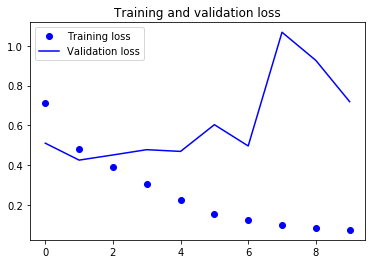

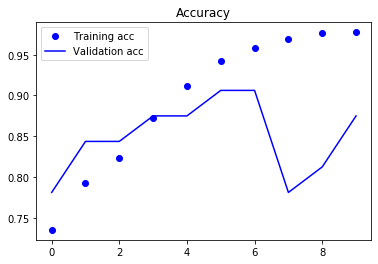

32/32 [==============================] - 0s 8ms/step
Test acc: 87.50%


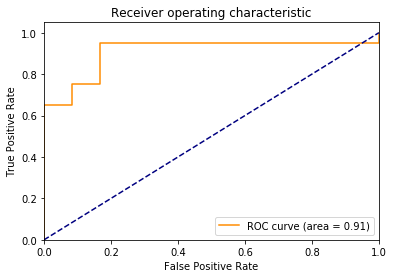

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.84
AUC for AD vs. CN = 0.99
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1413     292
1432     997
1483    5112
1480    5090
1408     166
1498    5231
349     4615
363     4730
397     5019
185     4035
202     4171
238     4507
245     4548
255     4629
279     4767
285     4806
295     4885
304     4918
308     4943
310     4960
1306    4105
1251      96
1252     112
1265     272
1283     767
56      4224
59      4262
91      4382
133     4520
144     4579
149     4598
159     4638
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
Train on 8834 samples, validate on 32 samples
Epoch 1/20
8834/8834 [==============================] - 206s 23ms/step - loss: 0.7189 - acc: 0.7349 - val_l

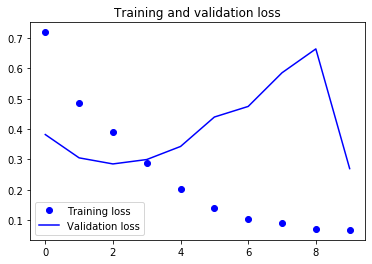

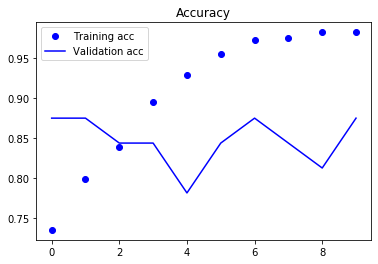

32/32 [==============================] - 0s 9ms/step
Test acc: 87.50%


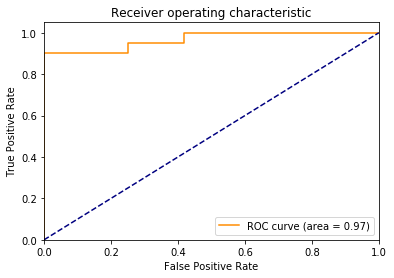

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.94
AUC for AD vs. CN = 1.00
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1463    5027
1491    5184
1481    5095
332     4282
348     4591
360     4718
368     4770
387     4911
388     4912
1358    1226
1372    4189
1393    6056
208     4243
212     4293
256     4631
258     4646
280     4769
293     4873
307     4936
312     4989
1268     352
1259     173
1278     680
32      4093
94      4386
99      4393
114     4448
132     4516
136     4555
137     4558
150     4599
175     4900
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
Train on 8834 samples, validate on 32 samples
Epoch 1/20
8834/8834 [==============================] - 206s 23ms/step - loss: 0.8198 - acc: 0.6817 - val_l

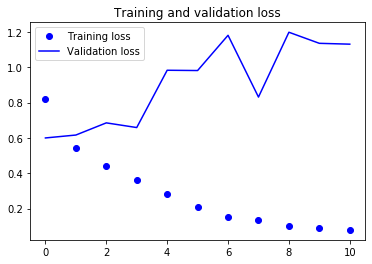

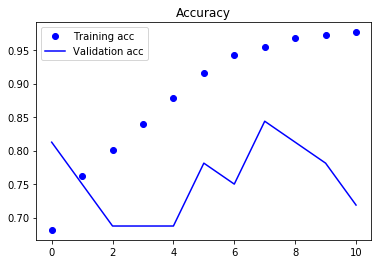

32/32 [==============================] - 0s 9ms/step
Test acc: 71.88%


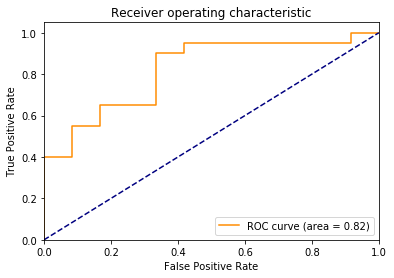

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.71
AUC for AD vs. CN = 0.95
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1424     729
1438    1057
1492    5187
1506    6303
1501    5251
1464    5028
1487    5138
336     4373
392     4962
1402    6427
1379    4302
1336     746
223     4394
232     4444
239     4510
240     4515
244     4538
252     4605
290     4852
299     4896
1248      61
1245      56
1287     896
1253     113
13      4020
54      4218
82      4350
85      4365
112     4441
116     4453
128     4503
171     4843
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
Train on 8834 samples, validate on 32 samples
Epoch 1/20
8834/8834 [==============================] - 207s 23ms/step - loss: 0.7132 - acc: 0.7399 - val_l

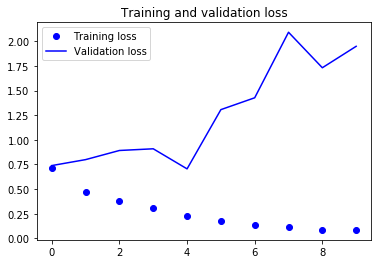

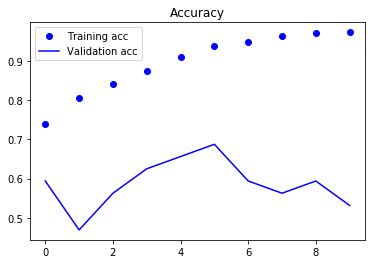

32/32 [==============================] - 0s 8ms/step
Test acc: 53.13%


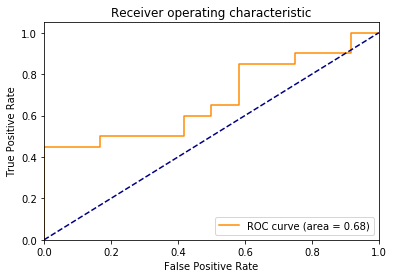

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.50
AUC for AD vs. CN = 0.90
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1493    5196
1471    5057
1469    5054
1418     408
1431     994
346     4583
355     4676
389     4940
396     5018
1375    4229
1396    6258
1344     989
1334     709
182     4029
191     4077
204     4210
205     4214
236     4489
251     4596
306     4929
1312    4270
1249      69
1311    4255
12      4018
24      4076
28      4084
41      4148
55      4222
74      4335
76      4339
127     4499
164     4652
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
Train on 8834 samples, validate on 32 samples
Epoch 1/20
8834/8834 [==============================] - 207s 23ms/step - loss: 0.7857 - acc: 0.7283 - val_l

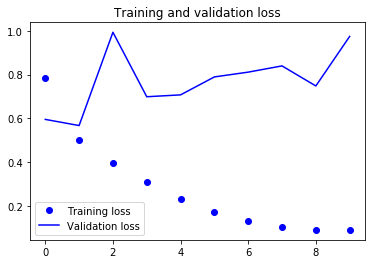

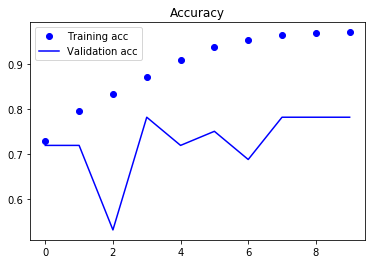

32/32 [==============================] - 0s 9ms/step
Test acc: 78.12%


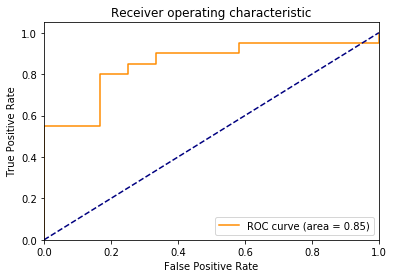

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.77
AUC for AD vs. CN = 0.95
Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    242
3    209
4    180
Name: Group, dtype: int64
1416     376
1429     906
1496    5210
1412     269
1406     135
1473    5059
1430     973
352     4657
384     4905
1382    4543
1367    1418
1400    6336
196     4122
220     4366
221     4377
243     4531
253     4611
260     4654
270     4721
277     4750
1305    4097
1246      58
1279     722
17      4032
27      4082
31      4092
46      4164
104     4410
113     4446
135     4552
139     4560
178     4952
Name: RID, dtype: int64
Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
Train on 8834 samples, validate on 32 samples
Epoch 1/20
8834/8834 [==============================] - 207s 23ms/step - loss: 0.6934 - acc: 0.7263 - val_l

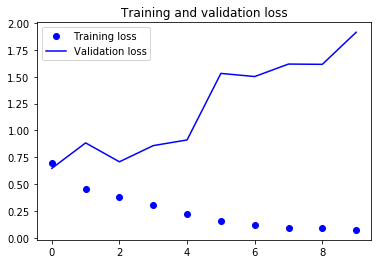

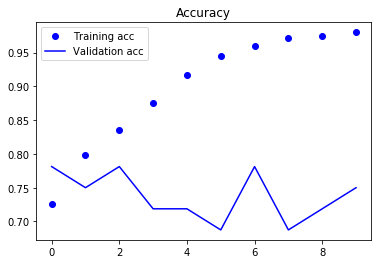

32/32 [==============================] - 0s 9ms/step
Test acc: 75.00%


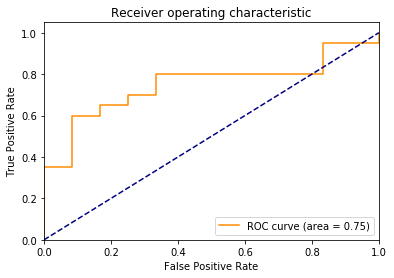

Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]
1    12
3    11
4     9
Name: Group, dtype: int64
AUC for MCI vs. CN = 0.68
AUC for AD vs. CN = 0.83


In [7]:
# Split data into training/validation and holdout test data
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
import gc
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # model will be trained on GPU 0

import keras
from keras import layers
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.optimizers import Adam
from keras import initializers
from keras.callbacks import EarlyStopping
import tensorflow as tf

acc_test, auc_test, auc_AD, auc_MCI = [], [], [], []
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
k = 1
for train_idX, test_idX in skf.split(X=images, y=grps.iloc[:, 0]): # split data as tenfold stratified cross-validation
    gc.collect() # run garbage collector
    print('Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]')
    print(grps.iloc[train_idX, :].Group.value_counts())
    testgrps = grps.iloc[test_idX, :]
    print(testgrps.RID) # prints test RID
    print('Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]')
    print(testgrps.Group.value_counts())
    
    # Setup CNN model
    tf.set_random_seed(k)
    #3D convnet model
    input_shape = images.shape[1:]

    model = models.Sequential()
    # Convolution Layers
    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu',
              input_shape=input_shape, data_format='channels_last'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())
    
    # FC layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate = 0.1))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(layers.Dropout(rate = 0.1))
    model.add(layers.Dense(2, activation='softmax', kernel_regularizer='l2'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if k==1:
        model.summary()
    
    traindat = images[train_idX, :]
    train_Y = labels[train_idX, :]
    testdat = images[test_idX, :]
    test_Y = labels[test_idX, :]
    #del images # try to free some memory

    num_train_scans = traindat.shape[0]
    num_copies = 14
    traindatA = np.zeros((num_train_scans*num_copies,) + traindat.shape[1:], dtype=traindat.dtype)
    traindatA[0:num_train_scans, :, :, :, :] = traindat
    traindatA[num_train_scans:(2*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 1) # move around x-axis
    traindatA[2*num_train_scans:(3*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 1)
    traindatA[3*num_train_scans:(4*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 2) # move around y-axis
    traindatA[4*num_train_scans:(5*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 2)
    traindatLRshifted = np.fliplr(traindat) # flip L/R
    traindatA[5*num_train_scans:(6*num_train_scans), :, :, :, :] = traindatLRshifted
    traindatA[6*num_train_scans:(7*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 1) # move around x-axis
    traindatA[7*num_train_scans:(8*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 1)
    traindatA[8*num_train_scans:(9*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 2) # move around y-axis
    traindatA[9*num_train_scans:(10*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 2)
    traindatA[10*num_train_scans:(11*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 3) # move around z-axis
    traindatA[11*num_train_scans:(12*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 3)
    traindatA[12*num_train_scans:(13*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 3)
    traindatA[13*num_train_scans:(14*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 3)

    train_label = np.concatenate((train_Y, train_Y, train_Y, train_Y, train_Y, train_Y, train_Y, train_Y,
                                  train_Y, train_Y, train_Y, train_Y, train_Y, train_Y),
                                 axis=0)

    # Fit model to training data
    batch_size = 12
    epochs = 20 # validation accuracy doesn't increase any more after 5 epochs
    hist = model.fit(traindatA, train_label, batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(testdat, test_Y), 
                     callbacks=[EarlyStopping(monitor='acc', mode='auto', verbose=1, patience=2, min_delta=0.02)])
    # Display models statistics
    from matplotlib import pyplot as plt
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    epochsr = range(len(loss))
    plt.figure()
    plt.plot(epochsr, loss, 'bo', label='Training loss')
    plt.plot(epochsr, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(epochsr, acc, 'bo', label='Training acc')
    plt.plot(epochsr, val_acc, 'b', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    mymodel = hist.model
    mymodel.save('mwp1_MNI/newmodel_wb_cv%d.hdf5' % k)
    k = k+1
    
    # Calculate accuracy for holdout test data
    scores = mymodel.evaluate(testdat, test_Y, batch_size=batch_size) #, verbose=0
    print("Test %s: %.2f%%" % (mymodel.metrics_names[1], scores[1]*100))
    acc_test.append(scores[1]*100)
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(testdat, batch_size=batch_size)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    auc_test.append(roc_auc[1])
    
    testgrps = grps.iloc[test_idX, :]
    #print(testgrps) # prints diagnosis and RID

    print('Distribution of diagnoses in holdout test data: [1=CN, 3=LMCI, 4=AD]')
    print(testgrps.Group.value_counts())

    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [3,4]:
      grpi = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], _ = roc_curve(test_Y[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])

    print('AUC for MCI vs. CN = %0.2f' % roc_auc[3])
    print('AUC for AD vs. CN = %0.2f' % roc_auc[4])
    auc_AD.append(roc_auc[4])
    auc_MCI.append(roc_auc[3])

In [8]:
# print model performance summary
from statistics import mean,stdev
print('Acc for all test data = %0.1f +/- %0.1f' % (mean(acc_test), stdev(acc_test)))
print('AUC for all test data = %0.3f +/- %0.3f' % (mean(auc_test), stdev(auc_test)))
print('AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))

Acc for all test data = 76.0 +/- 7.6
AUC for all test data = 0.850 +/- 0.068
AUC for MCI vs. CN = 0.770 +/- 0.103
AUC for AD vs. CN = 0.944 +/- 0.058


In [9]:
results = pd.DataFrame({'Accuracy_Test':acc_test, 'AUC_Test':auc_test, 'AUC_MCI':auc_MCI, 'AUC_AD':auc_AD})
print(results)

    Accuracy_Test  AUC_Test   AUC_MCI    AUC_AD
0       79.411765  0.846154  0.713287  0.992308
1       73.529412  0.836996  0.688811  1.000000
2       82.352942  0.912088  0.832168  1.000000
3       79.411765  0.890110  0.895105  0.884615
4       79.411764  0.882784  0.832168  0.938462
5       70.588236  0.853480  0.769231  0.946154
6       73.529414  0.816850  0.741259  0.900000
7       79.411765  0.952381  0.923077  0.984615
8       70.588235  0.798535  0.790210  0.807692
9       75.757576  0.892308  0.804196  1.000000
10      81.818182  0.892308  0.804196  1.000000
11      75.757577  0.811538  0.734266  0.905983
12      78.787879  0.850000  0.797203  0.914530
13      66.666667  0.784615  0.629371  0.974359
14      87.499999  0.908333  0.840909  0.990741
15      87.500000  0.966667  0.939394  1.000000
16      71.875001  0.820833  0.712121  0.953704
17      53.125000  0.679167  0.500000  0.898148
18      78.125000  0.850000  0.765152  0.953704
19      74.999999  0.750000  0.681818  0